# TODOs:
* Kevin: add legend for green and red bars
* Kevin: add task description
* Kevin: add task figure
* Kim: write second half of explanations / descriptions
* all: figure out timing and think about how to present it
* Maria: make sure hybRNNs are working and add visualization
* Kim: compare fit + actual model
* Kim: make sure masking is working in compute_likelihood
* Kim: make experiment_list for real-world dataset?


# CCN 2023 Tutorial
## Cognitive models of Behavior: Classical and Deep Learning Approaches

By Maria Eckstein, Kevin Miller, Kim Stachenfeld


# Getting started
### Hosted Colab
If you're working from a hosted colab (recommended):
1. File > Save a copy in Drive
2. Connect (top right) > Connect to a hosted runtime (GPU)

### Run locally as a Jupyter Notebook

You can also open the notebook in jupyter notebook or a locally hosted colab. To run locally, you can open a terminal window and download the code with:

```
git clone https://github.com/kstach01/CogModelingRNNsTutorial
```

### Jupyter notebook

To run as a jupyter notebook, you can in the terminal window run the following. Note that much of the formatting will be lost in Jupyter Notebook.

```
pip install notebook
git clone https://github.com/kstach01/CogModelingRNNsTutorial
cd CogModelingRNNsTutorial
jupyter notebook CCN2023_CogModelingRNNsTutorial2023.ipynb
```


### Local colab kernel

To run locally from colab, you can install some additional packages.

```
pip install notebook
git clone https://github.com/kstach01/CogModelingRNNsTutorial
cd CogModelingRNNsTutorial
jupyter notebook CCN2023_CogModelingRNNsTutorial2023.ipynb
```



# Hints

**Help:** To view information about a function or class, type `?` before the name of the function or class (For example, `?print` or `?str` will cause information about the print function or the string datatype to pop up on the right.)

**Table of Contents:** To view the Table of contents for the tutorial, you can click the icon in the top left with three dots next to three lines.

# Resources

**Code:** Additional code used by the tutorial can be found at [github.com/kstach01/CogModelingRNNsTutorial](https://github.com/kstach01/CogModelingRNNsTutorial). You are welcome to peruse it; however, it is not required to understand the tutorial.

# Introduction & Overview

In this Colab, you will learn how to implement and work with some of today's models.
* **Part 1: We will fit a Reinforcement Learning (RL) model to rat dataset.** We will learn *how to fit any computational model* (aka, what is a negative log likelihood?). And we will see *what we can learn from an RL model* (e.g., interpreting values and learning rates). We will also see what we *can't* learn from this model (think interpretability versus predictive power).

* **Part 2: We will fit a recurrent neural network (GRU) to the same dataset.** We will learn how to set up and train a neural network on a dataset (spoiler: not that hard). We will see how it solves some of the problems we encountered when working with the classic RL model (think predictive power). And we will also see that we now encounter new problems (think interpretability).

* **Part 3: We will talk about two methods that combine the strengths of the classical and the neural network approach.** There are *many* ways to solve this conundrum. We will talk about two specific ones: *Disentangled RNNs*, which produce interpretable models of behavior by forcing a neural network to disentangle its representation. And *Hybrid RNNs*, which test specific asssumptions of RL in a fully data-driven way, using neural networks.

*Note*: This Colab contains more code, exercises, and explanations than you will likely be able to get through during this tutorial. Have fun with it! Go as deep or as broad as you like, and spend more time on it at home.
In the tutorial, we will give an introduction to each subsection and then let you try the code and do the exercises on your own. We will bring the group back together for each subsection, so that everyone gets a taste of everything.

***Let's get started!***

# Imports

Go ahead and run the two cells below to install and load the required packages.

In [1]:
#@title Install required packages.
# !rm -rf CogModelingRNNsTutorial
# !git clone https://github.com/kstach01/CogModelingRNNsTutorial
# !pip install -e CogModelingRNNsTutorial/

In [2]:
#@title Imports + defaults settings.
%load_ext autoreload
%autoreload 2

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import warnings

warnings.filterwarnings("ignore")

try:
    from google.colab import files
    _ON_COLAB = True
except:
    _ON_COLAB = False

from CogModelingRNNsTutorial import bandits
from CogModelingRNNsTutorial import disrnn
from CogModelingRNNsTutorial import hybrnn
from CogModelingRNNsTutorial import plotting
from CogModelingRNNsTutorial import rat_data
from CogModelingRNNsTutorial import rnn_utils

/opt/miniconda3/lib/python3.8/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


# Part 0: Reinforcement Learning (RL)

In this section, you will get experience defining an RL agent and a simple two-armed bandit environment. The exercises in this section are intended to provide an intuition for the structure of the environment and how the agent works.

<font color='red'>TODO (can adapt from below)</font>

* Visual description of the task (i.e., trial-by-trial rat poke and reward plots)
* Task explanation in words (shorter than methods; longer than figure capture caption; enough so a 1st-year PhD student from a different field can understand it)

## The 2-armed bandit task

Where is this dataset is coming from?

We are working with an "N-armed bandit task". The figure below depicts what is happening on each trial from participants' perspective:

<center><img src="https://github.com/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/23-Friday/TaskOverview.png?raw=1" width=1000></center>

Take a moment to understand the task - everything else will make more sense if you have a good sense of what kind of data we are modeling!

On each trial of the task, participants see four items on the screen (which we sometimes call "bandits"). In the "participant choice" stage, participants pick one of the bandits, using four keys on their keyboard ("d", "f", "j", and "k"). Once the participant has made a choice, all bandits except the selected one disappear. Then, the reward is displayed: Participants can win between 1-100 points on each trial, depending on which bandit they choose. After the fixation cross, participants enter the next trial, which is structured in the same way. The goal of the task is to win as many points as possible. Participants complete a total of 150 trials, and thereby learn which bandits tend to give more points than others, so they can maximize the points they win.

We have written some code (in the `bandits` file on
[github](https://github.com/kstach01/CogModelingRNNsTutorial), in case you are curious) that implements RL agents (called `AgentQ`) and 2-armed bandit tasks (called `EnvironmentBanditsDrift`).

Let's get an instance of this agent (which we will call `agent`), and instance of this task (which we will call `environment`).
To create the task, we will need to tell it how many actions there are (`n_actions = 2` because we want to create a 2-armed bandit).
The agent will need to know what its "learning rate" (often called `alpha`) and its "inverse decision temperature" (often called `beta`) are. The agent also needs to know how many actions it has at its disposal.

Execute the cell below to do all of this.

<a name="define-agent-and-environment"></a>
## Define an agent and an environment

In [27]:
gen_alpha = 0.25
gen_beta = 5
n_actions = 2

environment = bandits.EnvironmentBanditsDrift(sigma=0.1, n_actions=n_actions)
agent = bandits.AgentQ(alpha=gen_alpha, beta=gen_beta, n_actions=environment.n_actions)

# For later: if you would like to check out a different environment, uncomment the lines below.
# environment = bandits.EnvironmentBanditsFlips(
#     block_flip_prob=0.02, reward_prob_high=0.8, reward_prob_low=0.2)

# For later: if you would like to check out a different agent, uncomment the lines below.
# agent = bandits.MysteryAgentQ(alpha=gen_alpha, beta=gen_beta, n_actions=environment.n_actions)

<a name="rl-in-a-nutshell"></a>
## RL in a nutshell

What our RL agent does is to learn "Q-values" for each action in order to decide what to do. When the agent receives a reward for an action it chose, it will increase the Q-value of this action; when it does not receive a reward for its action, it will decrease the corresponding action value.

Repeating this process over and over, the agent's Q-values will get closer and closer to the actual reward probabilities. This means that the agent will be able to choose actions well, and therefore maximize rewards.

Let's see what this looks like for a single trial. Execute the following cell and answer the following questions:
* What are the Q-values before the agent observes its first outcome (reward / no reward)?
* Which action did the agent choose?
* Did the agent get a reward or not?
* How did the Q-values change as a result of this outcome? What happened to the chosen action? What happened to the unchosen action?
* Execute the cell a few times to see what happens when the agent makes different choices and when it observes different outcomes.

**Deep Dive (optional): Q-values**

Remember that in RL, we always calculate reward prediction errors $\delta$:

$$\delta_t = r_t - Q_t(a_t)$$

In other words, we see how much reward $r$ we obtained on trial $t$ to get $r_t$. Then we check what the value $Q$ is of the action $a$ we chose on trial $t$ to get $Q_t(a_t)$. This entity $Q_t(a_t)$ is our "reward prediction".

Now, all that's left is to look at the difference between $Q_t(a_t)$ (our reward prediction) and the actual reward $r_t$, to obtain our "reward prediction error" $\delta_t$.

With the reward prediction error $\delta$, we can update our value $Q_t(a_t)$ to obtain $Q_{t+1}(a_t)$:

$$Q_{t+1}(a_t) = Q_t(a_t) + \alpha * \delta_t$$

For the update, we *could* simply add the reward prediction error $\delta_t$ to our old value estimate $Q_t$, to immediately arrive at $r_t$, the true outcome. However, we don't really want to move *all the way* from the old value $V_t$ to the actual outcome $r_t$. We only want to move *a little bit*, in order to keep around some of the things we have already learned in the past.

This is the reason why we first multiply $\delta_t$ by $\alpha$, the *learning rate*, before we add it to $Q_t(a_t)$. (The learning rate $\alpha$ is a number between 0 and 1 that "scales" the reward prediction error. For example, if $\alpha=0.25$, we move a quarter of the way from $Q_t$ to $r_t$.)

In [28]:
#@title Agent behavior: **One trial.**
agent.new_sess()
print("Agent's initial Q-values:", agent.q)
# print("Environment's Reward Probabilities:", environment.reward_probs)
choice = agent.get_choice()
print("Agent's choice", choice)
reward = environment.step(choice)
print("Reward provided by the environment: ", reward)
agent.update(choice=choice, reward=reward)
print("Agent's new Q-values:", agent.q)

Agent's initial Q-values: [0.5 0.5]
Agent's choice 0
Reward provided by the environment:  True
Agent's new Q-values: [0.625 0.5  ]


Now, let's see how the agent performs on the task, doing 200 trials in a row on the environment we specified. Execute the cell below to run the agent through the loop.

In [29]:
#@title Agent behavior: **One session**
n_trials = 200
choices = np.zeros(n_trials)
rewards = np.zeros(n_trials)
qs = np.zeros((n_trials, n_actions))
reward_probs = np.zeros((n_trials, n_actions))

# For each trial: Step the agent, step the environment, record everything
for trial_i in np.arange(n_trials):
  # Record environment reward probs and agent Qs
  reward_probs[trial_i, :] = environment.reward_probs
  qs[trial_i, :] = agent.q
  # First, agent makes a choice
  choice = agent.get_choice()
  # Then, environment computes a reward
  reward = environment.step(choice)
  # Finally, agent learns
  agent.update(choice, reward)
  # Log choice and reward
  choices[trial_i] = choice
  rewards[trial_i] = reward

Now, let's see what our agent did! Execute the cell below to plot the session we just created. Use the figure to answer the following questions:
* What do the orange and blue line represent?
* What do the vertical green and red ticks represent?
* What's the relationship between the ticks and the lines?
* [Bonus] What would an intelligent, rational, reward-optimizing agent do in this task? In other words, where would the ticks go for the smartest strategy you could imagine in this task?
* [Bonus] How does that compare to what we observe in the RL agent?

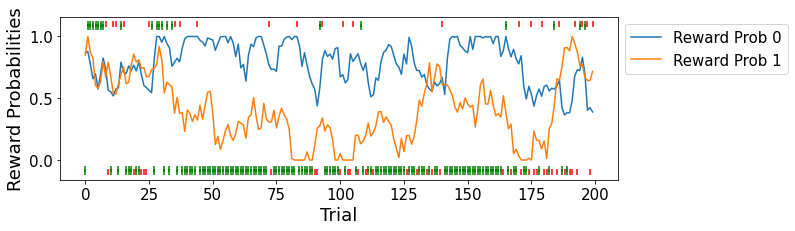

In [30]:
#@title Plot agent behavior
bandits.plot_session(
    choices=choices, rewards=rewards, timeseries=reward_probs,
    timeseries_name='Reward Probabilities',
    labels=[f'Reward Prob {a}' for a in range(n_actions)])


Let's understand how the agent made the choices it made - let's look under the hood. Execute the cell below and answer these questions:
* What do the orange and blue line represent? (Spoiler: It's different from before)
* What happens to the orange line when there's a green tick on the top of the figure? What happens when there's a red tick on the top? What happens to the orange line when there are ticks on the bottom side?
* How about the blue line? Which ticks is it sensitive to?
* How do you explain the movements of the lines? (Hint: This is RL in action! Look back at [RL in a nutshell](#rl-in-a-nutshell))
* How are Q-values and actions related? In other words, how do the orange and blue lines in this figure compare to the orange and blue lines above?

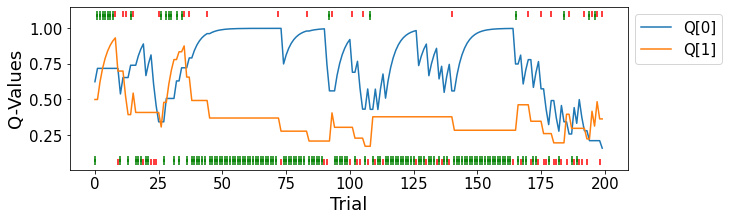

In [31]:
#@title Plot agent Q-values
bandits.plot_session(
    choices=choices,
    rewards=rewards,
    timeseries=qs,
    timeseries_name='Q-Values',
    labels=[f'Q[{a}]' for a in range(n_actions)])

Now that we know what Q-values are, how a Q-learning agent works, and how it behaves, let's run a whole bunch of them. (This might take a few seconds.)

In [32]:
#@title Generate synthetic data: **Whole dataset**
n_trials_per_session = 200
n_sessions = 100
dataset_train_to_view, experiment_list_to_view = bandits.create_dataset(
    agent=agent, environment=environment,
    n_trials_per_session=n_trials_per_session, n_sessions=n_sessions)

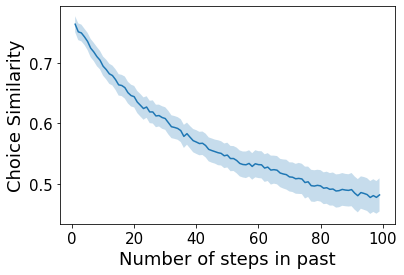

In [33]:
#@title Run some diagnostics to characterize the dataset
plotting.plot_action_similarity_to_history(experiment_list_to_view, n_steps_back=100)

<font color='red'>TODO:</font>

Could plot left prob on x-axis, proportion left choices on y; same for right; i.e., just pull that plat apart

## Exercise: Experiment with different values of alpha and beta.

* Go back to [the cell where we defined the agent](#define-agent-and-environment)

* Change the values of the `alpha` parameter (e.g., from 0.25 to 0.75), then run all the cells until here. (Note: `alpha` lives between [0, 1].)
* What changes in the behavior of the agent when you change `alpha`? What changes in the Q-values?
* Why does `alpha` change the behavior, Q-values, and proportion of left choices affect in the way it does? (Hint: `alpha` is also called the "learning rate" of the agent.)

* Change the values of the `beta` parameter, then run all the cells until here (e.g., set `alpha` back to 0.25, then set beta from 5 to 1). (Note: `beta` usually is >= 1.)
* What changes in the behavior of the agent when you change `beta`? Does anything change in the Q-values? What happens to the proportion of left-choices (last plot)?
* Why does `beta` change the behavior, Q-values, and proportion of left choices affect in the way it does? (Hint: `beta` is also called the "inverse decision temperature", "inverse noise", or "inverse exploration".)

<a name="fit-classic-cognitive-model"></a>
# Part 1: Fit a Classic Cognitive Model

Now that we have a thorough understanding of how our RL agent works, we will learn how to fit a cognitive model. In the following cell, select `dataset_type = SyntheticVanillaQ` from the dropdown menu on the right. (This will give us a dataset similar to the one above, where a Q-learning agent is performing a drifting 2-armed bandit task.) Select your preferred `alpha` (e.g., 0.25), `beta` (e.g., 5) parameters, and other parameters. Then run the cell.

(In later exercises, we will substitute in different datasets by selecting different values for dataset_type from the dropdown menu below):
* `SyntheticMysteryQ` A more sophisticated "mystery agent", for which the cognitive model does not exactly match the agent
* `RealWorldRatDataset` real data from rats performing a bandit task with reversals. In order to access these, you'll first:
  1. Download any one data file from [https://drive.google.com/drive/folders/1UyV7Ne_-8cxSgIZA6ql_LulwJG5qMbvM?usp=sharing](https://drive.google.com/drive/folders/1UyV7Ne_-8cxSgIZA6ql_LulwJG5qMbvM?usp=sharing)
  2. When prompted to select a file to upload, select the file you've downloaded. The upload will take several seconds.

In [69]:
#@title Select dataset type.
#@markdown ## Select dataset:

dataset_type = 'SyntheticMysteryQ'  #@param ['SyntheticVanillaQ', 'SyntheticMysteryQ', 'RealWorldRatDataset']
is_synthetic = dataset_type.startswith('Synthetic')


#@markdown Set up parameters for synthetic data generation:
if is_synthetic:
  gen_alpha = .25 #@param
  gen_beta = 5 #@param
  mystery_param = -2  #@param
  n_trials_per_session = 200  #@param
  n_sessions = 220  #@param
  sigma = .1  #@param
  environment = bandits.EnvironmentBanditsDrift(sigma=sigma)

  # Set up agent.
  agent = {
      'SyntheticVanillaQ': bandits.VanillaAgentQ(gen_alpha, gen_beta),
      'SyntheticMysteryQ': bandits.MysteryAgentQ(gen_alpha, gen_beta, mystery_param=mystery_param),
      }[dataset_type]

  dataset_train, experiment_list_train = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions)

  dataset_test, experiment_list_test = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions)

#@markdown Set up parameters for loading rat data from Miller et al 2019.
elif dataset_type == 'RealWorldRatDataset':
  gen_alpha = "unknown"
  gen_beta = "unknown"
  sigma = 0.1  #@param
  environment = bandits.EnvironmentBanditsDrift(sigma=sigma)

  upload_new_data_file = "False" #@param ["True", "False"]
  upload_new_data_file = upload_new_data_file == "True"

  if upload_new_data_file:
    url = "https://drive.google.com/drive/folders/1UyV7Ne_-8cxSgIZA6ql_LulwJG5qMbvM?usp=sharing"
    print(f'NOTE: Before you can upload a data file, you will need to download from from\n{url}\n')
    uploaded = files.upload()
    FNAMES_ = list(uploaded.keys())
    FNAME_ = FNAMES_[0]
    if len(FNAMES_) > 1:
      print(f'\nWARNING: More than one file uploaded -- using only {FNAME_}.')

  else:
    if "FNAME_" not in list(locals().keys()):
      raise ValueError('No files found. Please change upload_new_data_file to True and upload a file.\nSee instructions above for more information.')

  dataset_train, dataset_test = rat_data.format_into_datasets(
      *rat_data.load_data_for_one_rat(FNAME_, '.')[:2], rnn_utils.DatasetRNN)
  n_trials_per_session, n_sessions, _ = dataset_train._xs.shape

else:
  raise NotImplementedError(
      (f'dataset_type {dataset_type} not implemented. '
       'Please select from drop-down list.'))



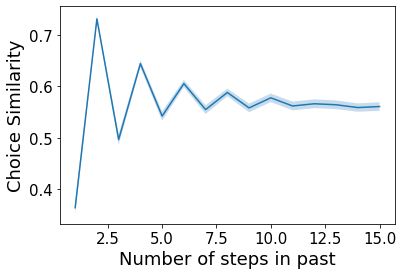

In [70]:
plotting.plot_action_similarity_to_history(experiment_list_train)

<font color='red'>TODO: Rephrase to work with this tutorial</font>
## RL as a Model of Human Behavior

We want to test if humans might be using RL in this task. How can we do this?

To see if humans use RL, we "fit" the RL model to human behavior. This means that we "squeeze" and "stretch" the RL agent (the cookie cutter) until it produces behavior that corresponds to the human behavior (dough pancake).

In this case, the "squeezing" and "stretching" consists of increasing or decreasing the values of the *free parameters* of the model, learning rate $\alpha$ and inverse decision temperature $\beta$.

How do we know if we need to change the values of $\alpha$ and $\beta$? By checking how close the behavior of the model is to human behavior (i.e., how similar the model pancake is to the human pancake). The closer the model behavior matches human behavior, the better the model "fits" the human dataset, and the less we have to change the parameters.

On the other hand, the more different the model behavior is from human behavior, the more we have to still wiggle on $\alpha$ and $\beta$ to get it to match more closely. We want the best possible fit, so we are looking for the values of $\alpha$ and $\beta$ that maximize the similarity between human and model behavior. To do this, we will *maximizes the probability* that the RL agent chooses the same actions that humans have chosen.

**Saying the same thing but more "mathy", our goal is to find the values of our model parameters ($\alpha$ and $\beta$) that maximize the likelihood of the observed (human) behavior under the model.**

To do this, we will:
* Write a function that calculates the negative log likelihood (NLL)
* Set up an optimizer that will minimize the NLL
* The smallest NLL corresponds to the best parameters! The model is fitted.

The cell below provides a function that calculates the log likelihood for us. It takes a dataset (`dataset`, e.g., our syntheticly created behavior), a model (`model_fun`, e.g., our Q-learning agent), and model parameters (`params`, e.g., a learning rate `alpha` and an inverse decision temperature `beta`) as inputs.
It returns the normalized likelihood of the dataset under the model and the parameters as an output.

<font color='red'>TODO: Rephrase to work with this tutorial</font>

The likelihood of our dataset under the model is simply the probability each choice we see in the dataset would have occurred in the model:
$$p(dataset) = \prod_{s=0}^{100} \prod_{t=0}^{150} p(a_{st})$$
This is the probability of each action at each trial $t$, for each subject $s$, which our model (aka RL agent) produces.

Because this is hard to calculate (numbers will get very small with so many multiplications), we take a trick: We take the log and add instead:
$$p(dataset) = \prod_{s=0}^{100} \prod_{t=0}^{150}p(a_{st}) = \sum_{s=0}^{100} \sum_{t=0}^{150} log(p(a_{st}))$$

And because we don't want the number of trials (150) and subjects (100) to influence our results, we often normalize the log-likelihood:
$$p(dataset) \propto \sum_{s=0}^{n_s} \sum_{t=0}^{n_t} log(p(a_{st})) \ / \ n_s \ / \ n_t$$

In [71]:
#@title Compute log-likelihood
def compute_log_likelihood(dataset, model_fun, params):

  xs, actual_choices = next(dataset)
  n_trials_per_session, n_sessions = actual_choices.shape[:2]
  model_outputs, model_states = rnn_utils.eval_model(model_fun, params, xs)

  predicted_log_choice_probabilities = np.array(jax.nn.log_softmax(model_outputs[:, :, :2]))

  log_likelihood = 0
  n = 0  # Total number of trials across sessions.
  for sess_i in range(n_sessions):
    for trial_i in range(n_trials_per_session):
      actual_choice = int(actual_choices[trial_i, sess_i])
      if actual_choice >= 0:  # values < 0 are invalid trials which we ignore.
        log_likelihood += predicted_log_choice_probabilities[trial_i, sess_i, actual_choice]
        n += 1

  normalized_likelihood = np.exp(log_likelihood / n)

  print(f'Normalized Likelihood: {100 * normalized_likelihood:.1f}%')

  return normalized_likelihood

Let's see if this all makes sense. Answer the following questions:

* Which values of `alpha` and `beta` should give us the **highest** likelihood for the current dataset? Why is that?  
* Which values should give us very **low** likelihoods?

Now let's see if we were right. Use the cell below to calculate the likelihoods for some different values of `alpha` and `beta`. Type the values into the interface on the right, and execute the cell to calculate the likelihood. Try a few different combinations to see if your intuition was right!

In [72]:
#@title Calculate the log likelihoods for example parameters
test_alpha = 0.25 #@param
test_beta = 2 #@param

def inverse_sigmoid(x):
  return np.log(x/(1-x))

print('Calculating the log likelihood for alpha = {} and beta = {}.'.format(test_alpha, test_beta))
params = {'hk_agent_q': {'alpha_unsigmoid': inverse_sigmoid(jnp.array([test_alpha])), 'beta': jnp.array([test_beta])}}
_ = compute_log_likelihood(dataset_train, bandits.HkAgentQ, params)

Calculating the log likelihood for alpha = 0.25 and beta = 2.
Normalized Likelihood: 55.1%


<font color='red'>TODO: Rephrase to work with this tutorial</font>

If we were to calculate the LL for each combination of $\alpha \in [0, 1]$ and $\beta \in [0, 30]$, this is what we would get. (The red cross marks the smallest NLL, aka best parameter combination):

<center><img src="https://github.com/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/23-Friday/NllGrid.png?raw=1" width=700></center>

We now have everything in place to fit our model! We have a function that calculates the LL for a model (e.g., Q-learning) and some parameters (e.g., `alpha` and `beta`), on any dataset. All that's left is find the largest possible LL, and we'll have the optimal parameters! (To do this, we usually find the *smallest* possible *negative* LL or NLL, because finding minima is easier than finding maxima. But the logic is the same.)

Congrats on making it until here---this is model fitting in a nutshell!

The next cell does just that: It takes an agent (our Q-learnner) and a dataset (the synthetic one we made above), and finds the parameters with the best LL.

In [73]:
#@title Fit parameters
rl_params, _ = rnn_utils.fit_model(
    model_fun=bandits.HkAgentQ,
    dataset=dataset_train,
    loss_fun='categorical',
    optimizer=optax.adam(1e-1),
    convergence_thresh=1e-5,
    n_steps_per_call=100,
    n_steps_max=1000)

Step 100 of 100; Loss: 2.6227e+04. (Time: 1.1s)Model not yet converged - Running more steps of gradient descent. Time elapsed = {time.time()-t_start:0.1}s.
Step 100 of 100; Loss: 2.6227e+04. (Time: 0.8s)Model Converged! Time elapsed = {time.time()-t_start:0.1}s.


While the cell is running, answer the following questions:

* Which parameters will the function return? I.e., what will the value be of `alpha`? And will the value be of `beta`? Why?
* Would the result be different for a different dataset? Why?

Now let's see! Execute the cell below to see what parameters we have fitted.

In [74]:
fit_alpha = jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0])
fit_beta = rl_params['hk_agent_q']['beta'][0]

print('Generative beta was: ', gen_beta)
print('Recovered beta was: ', fit_beta)
print('Generative alpha was: ', gen_alpha)
print('Recovered alpha was: ', fit_alpha)

Generative beta was:  5
Recovered beta was:  2.2309244
Generative alpha was:  0.25
Recovered alpha was:  0.24439761


* What do you think? Was our fitting successful?
* What can we learn from the results? What did the model fitting achieve?
* How does this model do in terms of interpretability? (A good way to think about his might be to think about the variables in the model: `alpha`, `beta`, Q-values. What does it mean that the model is build on these variables? How could we use them in a cognitive neurscience study?)
* How does this model do in terms of predictive power? (You can make a guess here - keep the question in mind until we have also fitted the neural network model in the next section.)

## Qualitative Model Fit

<font color='red'>TODO:</font>

* repeat the model diagnostics, and compare to the fitted dataset
* estimate the values of an example session from the fitted dataset (for synthetic data, this will be identical to the plot we made above. for the rat data, it will be different. make the point that we could use the values as regressors to understand brain activity, for example striatal dopamine.)

In [75]:
#@title Synthesize a dataset using the fitted agent
rl_agent = bandits.AgentNetwork(bandits.HkAgentQ, rl_params)
_, experiment_list_rl = bandits.create_dataset(rl_agent, environment, n_trials_per_session, n_sessions)

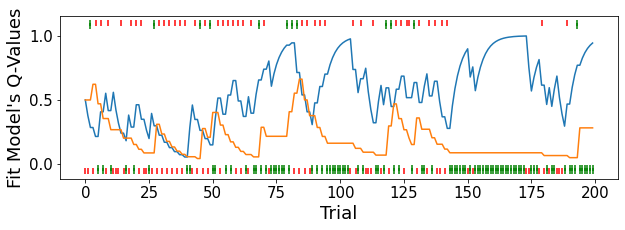

In [76]:
#@title Plot internal workings of the model
# Run the agent on a session
xs, ys = next(dataset_train)
network_outputs, network_states = rnn_utils.eval_model(bandits.HkAgentQ, rl_params, xs)

# Plot session
network_states = np.array(network_states)
sess_i = 0
trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
rl_activations = network_states[:trial_end, sess_i, :]
bandits.plot_session(
    choices=choices, rewards=rewards, timeseries=rl_activations,
    timeseries_name="Fit Model's Q-Values")

Total Reward Rate is: 57.775%
Total Reward Rate is: 57.957%
Total Reward Rate is: 57.384%


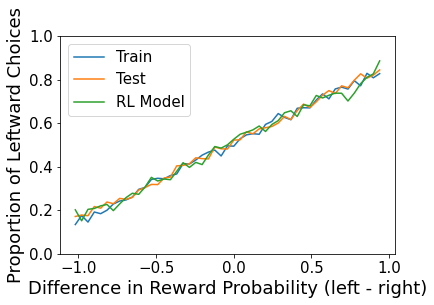

In [77]:
#@title Plot behavior diagnostics
bandits.show_valuemetric(experiment_list_train, label='Train')
bandits.show_total_reward_rate(experiment_list_train)

bandits.show_valuemetric(experiment_list_test, label='Test')
bandits.show_total_reward_rate(experiment_list_test)

bandits.show_valuemetric(experiment_list_rl, label='RL Model')
bandits.show_total_reward_rate(experiment_list_rl)
plt.legend()

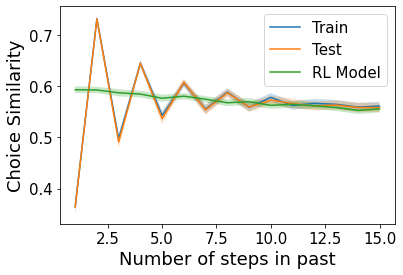

In [79]:
plotting.plot_action_similarity_to_history(
    experiment_list_train,
    experiment_list_test,
    experiment_list_rl,
    n_steps_back=16,
    labels=['Train', 'Test', 'RL Model'])

## Quantitative Model Fit

Oftentimes, we want to know the "quality of fit" of a model. This is the case when we fit several models (as we will do shortly), and want to know which one captures the dataset best.

A common choice to calculate model fit are measures such as AIC and BIC. However, these don't work well once we deal with neural networks. (The reason is that the AIC and BIC penalize models for their complexity, usually by counting "free parameters". But it is very hard to determine the model complexity of a neural network, or break it down to the number of free parameters.)

Another choice, which is more common in machine learning, is to calculate the fit on a "held-out" dataset - a dataset that the model has not seen during training, and hence does not know. The idea is that if the model is still able to predict the behavior in this new dataset, it captures the underlying patterns well. (This also solves a big problem when working with neural networks, called "overfitting": Because neural networks have so many free parameters and are so flexible, they can "overfit" to their training data - basically just memorizing it - without learning anything deeper about it. If that's the case, the model will fit very poorly to a held-out dataset.)

The good thing about calculating a model's quality of fit in terms of the held-out prediction is that it works for both classical models (like the Q-learning model we've used here), and for neural network models.

Let's go ahead and do this!

All we have to do is to load our testing dataset (in this case, create a new synthetic dataset). And the calculate the LL of our fitted model on this dataset.

In [80]:
# Report quality of fit to held-out dataset
print('Normalized Likelihoods for Q-Learning Model')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, bandits.HkAgentQ, params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, bandits.HkAgentQ, params)

Normalized Likelihoods for Q-Learning Model
Training Dataset
Normalized Likelihood: 55.1%
Held-Out Dataset
Normalized Likelihood: 54.9%


* What do you observe? Are the likelihoods the same or different?
* What do the numbers mean? In our log-likelihood function, we have calculated the probability that the model assigns to each choice made in the dataset. We basically calculated an average log-likelihood for our dataset under the model. What we did here is to simply that log-likelihood $log(p(data|model, params))$ back into a regular likelihood $p(data|model, params)$. In other words, a probability of 66\% (yours might be different) means that the model predicts about 66\% of the choices in the dataset correctly.

# Part 2: Fitting with Standard RNNs

Now that we have seen what it is like to fit a classic cognitive model, let us see how we can fit a neural network to the data!

The logic will be very similar:
* We will set up the RNN model. Just like the classic model, the RNN will choose actions in the 2-armed bandit task. It will make a choice, observe a reward, and then predict the probability of the subsequent choice. We will use this probability prediction to calculate our likelihood, just like we did above. (<font color='red'>You can read more about GRUs here: </font>)
* Once we have the likelihood, we do the same we did above: We find the model parameters that maximize the likelihood, because these provide the best fit for the dataset. What is different here is the nature of the free parameters: Where we had `alpha` and `beta` above, here we have biases `b` and weights `W`. (It is not too important what exactly these are for now.)
* After fitting the model, we can again calculate the model fit, aka held-out likelihood. We will use the same training and testing dataset as we did before, so we will be able to directly compare how the predictions of this model compare to the predictions of the Q-learning model.

<font color='red'>TODO: Add a simple graphic depicting biases and weights from the internet</font>

In [81]:
#@title Set up the RNN (GRU) Model
n_hidden = 16  #@param
def make_gru():
  model = hk.DeepRNN(
      [hk.GRU(n_hidden), hk.Linear(output_size=2)]
  )
  return model

In [82]:
#@title Fit the GRU model
#@markdown You can experiment with values, but n_steps_max = 5000 was used for testing.
n_steps_max = 5000 #@param
optimizer = optax.adam(learning_rate=1e-2)
gru_params, _ = rnn_utils.fit_model(
    model_fun=make_gru,
    dataset=dataset_train,
    optimizer=optimizer,
    convergence_thresh=1e-3,
    n_steps_max=n_steps_max)

Step 500 of 500; Loss: 1.8083e+04. (Time: 15.3s)Model not yet converged - Running more steps of gradient descent. Time elapsed = {time.time()-t_start:0.1}s.
Step 500 of 500; Loss: 1.7980e+04. (Time: 15.1s)Model not yet converged (convergence_value = 0.00569443) - Running more steps of gradient descent. Time elapsed = {time.time()-t_start:0.1}s.
Step 500 of 500; Loss: 1.7870e+04. (Time: 15.5s)Model not yet converged (convergence_value = 0.006154156) - Running more steps of gradient descent. Time elapsed = {time.time()-t_start:0.1}s.
Step 500 of 500; Loss: 1.9101e+04. (Time: 15.3s)Model not yet converged (convergence_value = 0.06891343) - Running more steps of gradient descent. Time elapsed = {time.time()-t_start:0.1}s.
Step 500 of 500; Loss: 1.7943e+04. (Time: 15.3s)Model not yet converged (convergence_value = 0.06062856) - Running more steps of gradient descent. Time elapsed = {time.time()-t_start:0.1}s.
Step 500 of 500; Loss: 1.7669e+04. (Time: 15.0s)Model not yet converged (convergen

Let's look at how well the model fits the dataset!
* Before you execute the next cell, what is your prediction? How well will this model fit, compared to the Q-learning model above?
* Now, execute the cell - what do you observe?
* Why is this? (Hint: think about which dataset we fitted here)
* (Solution: You will likely observe that the fit is similar when you are working with the first synthetic dataset. The reason is that the Q-learning model can explain as much data as any other, even much more powerful, model, because it is the true underlying model. When you are working with a different dataset, like the second synthetic one, or the real rat data, you will likely observe that the GRU actually fits better. This is the increase in predictive power.)

In [83]:
#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for GRU')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, make_gru, gru_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_gru, gru_params)

Normalized Likelihoods for GRU
Training Dataset
Normalized Likelihood: 67.2%
Held-Out Dataset
Normalized Likelihood: 63.9%


Now that we have thought about model fit (predictive power), let's think about interpretability.
* Before you run the next cell, think about what it would mean for the model to be interpretable. In other words, how could we use the model to understand the cognitive better than agents were using in the dataset? (Hint: Remember what we did in the case of the Q-learning model: We could plot the values over time, and get a good sense of why it chose the actions it chose at which trials.)
* Now, execute the next cell. What does the plot show? What does this mean in terms of interpretability?

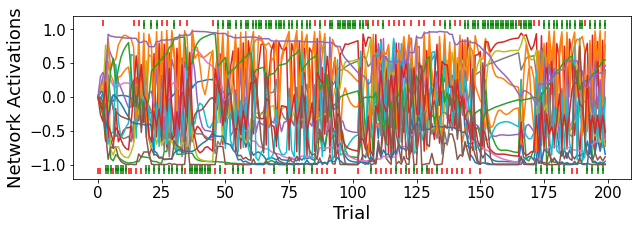

In [84]:
#@title Plot internal workings of the model
# Run the agent on a session
xs, ys = next(dataset_test)
network_outputs, network_states = rnn_utils.eval_model(make_gru, gru_params, xs)

# Plot session
network_states = np.array(network_states)
sess_i = 0

trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
gru_activations = network_states[:trial_end, 0, sess_i, :]
bandits.plot_session(
    choices=choices,
    rewards=rewards,
    timeseries=gru_activations,
    timeseries_name='Network Activations')

Now, let's run this new model "open-loop": We will treat it just a rat in our experiment and let it make choices so we can analyze its behavior. Execute the next cell to create a dataset of GRU choices on the 2-armed bandit task.

In [ ]:
#@title Synthesize a dataset using the fit network
gru_agent = bandits.AgentNetwork(make_gru, gru_params)
_, experiment_list_gru = bandits.create_dataset(gru_agent, environment, n_trials_per_session, n_sessions)

Now, let's see how behavior compares to the behavior of the original dataset, looking at the same diagnostic plots.

Total Reward Rate is: 51.045%
Total Reward Rate is: 53.409%
Total Reward Rate is: 54.636%
Total Reward Rate is: 52.998%


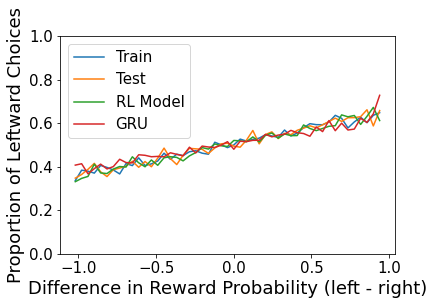

In [577]:
#@title Plot behavior diagnostics
bandits.show_valuemetric(experiment_list_train, label='Train')
bandits.show_total_reward_rate(experiment_list_train)

bandits.show_valuemetric(experiment_list_test, label='Test')
bandits.show_total_reward_rate(experiment_list_test)

bandits.show_valuemetric(experiment_list_rl, label='RL Model')
bandits.show_total_reward_rate(experiment_list_rl)

bandits.show_valuemetric(experiment_list_gru, label='GRU')
bandits.show_total_reward_rate(experiment_list_gru)

plt.legend()


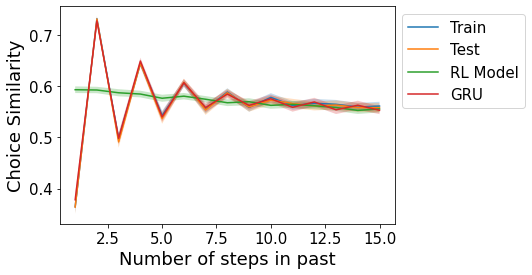

In [89]:
plotting.plot_action_similarity_to_history(
    experiment_list_train,
    experiment_list_test,
    experiment_list_rl,
    experiment_list_gru,
    n_steps_back=16,
    labels=['Train', 'Test', 'RL Model', 'GRU'])



# Part 3: Fitting with "Interpretable" RNNs

## Disentangled RNNs

In [186]:
#@title Set up Disentangled RNN.
#@markdown Number of latent units.
latent_size = 5  #@param

#@markdown Number of hidden units in each of the two layers of the update MLP.
update_mlp_shape = (3,3,)  #@param

#@markdown Number of hidden units in each of the two layers of the choice MLP.
choice_mlp_shape = (2,)

def make_disrnn():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2,
                          eval_mode=True)
  return model


optimizer = optax.adam(learning_rate=1e-2)

In [187]:
#@title Fit disRNN with no penalty at first, to get good quality-of-fit
#@markdown You can experiment with different values, but colab has been tested with 1000.
print(('Warning: this step can be rather time consuming. If you are not running on a GPU\n, '
       'you may want to set n_steps to a very low value and return to the exercise when you \n'
       'have access to hardware acceleration.'))
n_steps = 1000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = dataset_train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=False,
    truncate_seq_length=200,
)

, you may want to set n_steps to a very low value and return to the exercise when you 
have access to hardware acceleration.
Step 1000 of 1000; Loss: 1.8232e+04. (Time: 153.9s)

Step 3000 of 3000; Loss: 1.8881e+04. (Time: 450.2s)

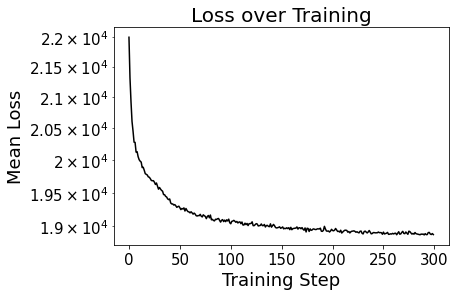

In [188]:
#@title Now fit more steps with a penalty, to encourage it to find a simple solution
#@markdown You can experiment with different values, but colab has been tested with 3000.
n_steps = 3000  #@param
information_penalty = 1e-3  #@param

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = dataset_train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    params=disrnn_params,
    opt_state=opt_state,
    penalty_scale=information_penalty,
    n_steps=n_steps,
    truncate_seq_length=200,
)

[<Figure size 1152x396 with 4 Axes>,
 <Figure size 1152x396 with 4 Axes>,
 <Figure size 1008x396 with 2 Axes>,
 <Figure size 288x396 with 1 Axes>]

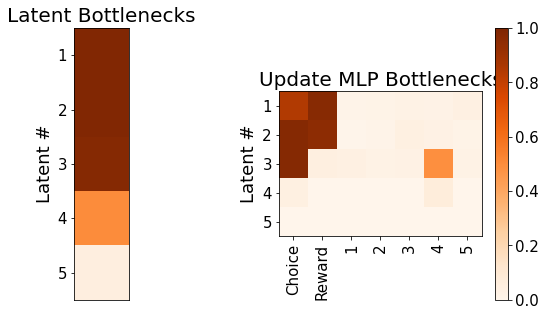

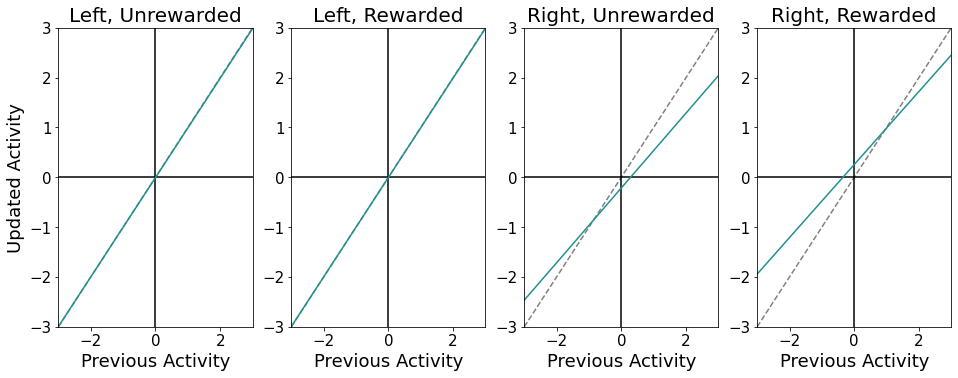

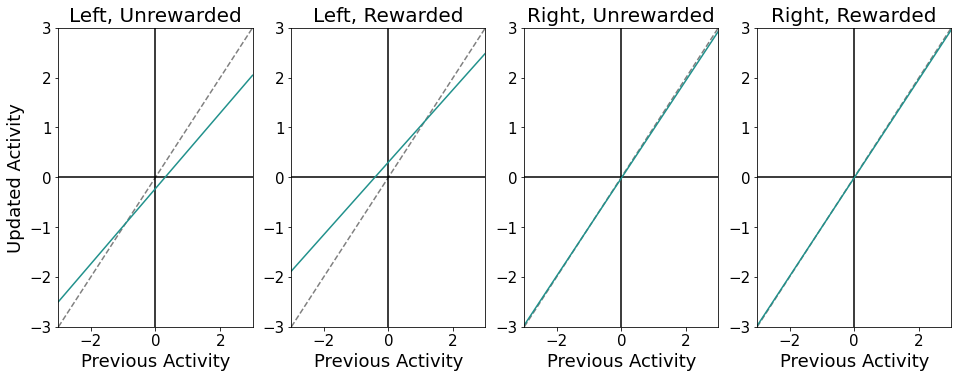

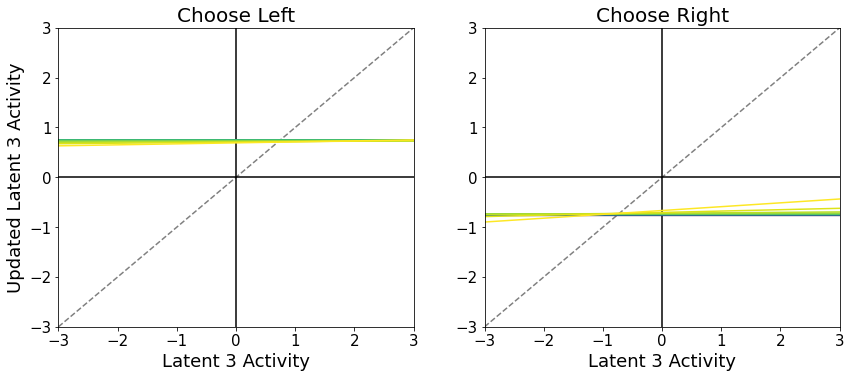

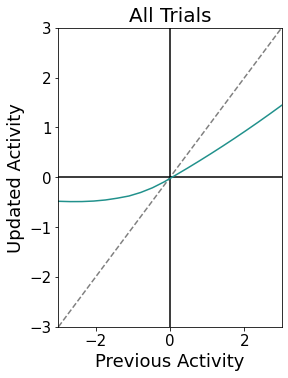

In [189]:
#@title Visualize bottleneck latents + learned update.
disrnn.plot_bottlenecks(disrnn_params)
disrnn.plot_update_rules(disrnn_params, make_disrnn_eval)

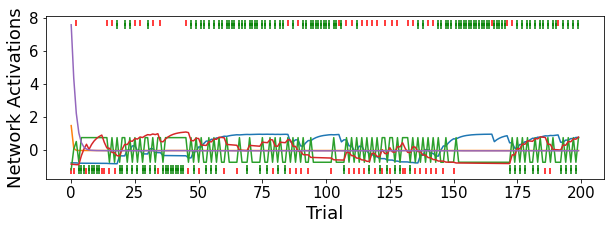

In [190]:
#@title Plot example session
xs, ys = next(dataset_test)
sess_i = 0
trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
network_outputs, network_states = rnn_utils.eval_model(
    make_disrnn_eval, disrnn_params, xs[:trial_end, sess_i:sess_i+1])
network_states = np.array(network_states)
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
disrnn_activations = network_states[:trial_end, sess_i, :]
bandits.plot_session(choices=choices,
                     rewards=rewards,
                     timeseries=disrnn_activations,
                     timeseries_name='Network Activations')

In [191]:
print('Normalized Likelihoods for Disentangled RNN')
print('Training Dataset')
training_likelihood = compute_log_likelihood(
    dataset_train, make_disrnn_eval, disrnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(
    dataset_test, make_disrnn_eval, disrnn_params)

Normalized Likelihoods for Disentangled RNN
Training Dataset
Normalized Likelihood: 66.1%
Held-Out Dataset
Normalized Likelihood: 65.8%


In [192]:
# Synthesize a dataset using the fit network
disrnn_agent = bandits.AgentNetwork(make_disrnn_eval, disrnn_params)

_, experiment_list_disrnn = bandits.create_dataset(
    disrnn_agent, environment, n_trials_per_session, n_sessions)

Total Reward Rate is: 57.775%
Total Reward Rate is: 57.957%
Total Reward Rate is: 57.384%
Total Reward Rate is: 57.145%
Total Reward Rate is: 58.266%


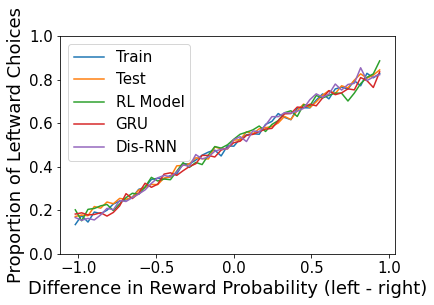

In [193]:
#@title Plot behavior diagnostics
bandits.show_valuemetric(experiment_list_train, label='Train')
bandits.show_total_reward_rate(experiment_list_train)

bandits.show_valuemetric(experiment_list_test, label='Test')
bandits.show_total_reward_rate(experiment_list_test)

bandits.show_valuemetric(experiment_list_rl, label='RL Model')
bandits.show_total_reward_rate(experiment_list_rl)

bandits.show_valuemetric(experiment_list_gru, label='GRU')
bandits.show_total_reward_rate(experiment_list_gru)

bandits.show_valuemetric(experiment_list_disrnn, label='Dis-RNN')
bandits.show_total_reward_rate(experiment_list_disrnn)

plt.legend()


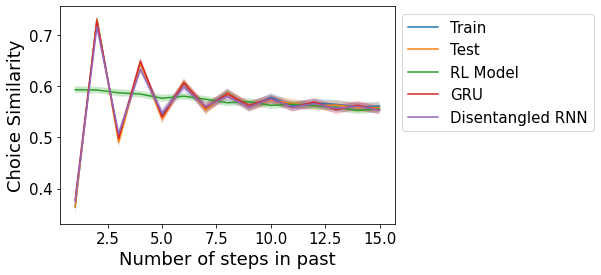

In [194]:
plotting.plot_action_similarity_to_history(
    experiment_list_train,
    experiment_list_test,
    experiment_list_rl,
    experiment_list_gru,
    experiment_list_disrnn,
    n_steps_back=16,
    labels=['Train', 'Test', 'RL Model', 'GRU', 'Disentangled RNN'])



## Hybrid RNNs

Maria to-do

In [167]:
#@title Set up Hybrid RNN.

#@markdown Is the model recurrent (ie can it see the hidden state from the previous step)
use_hidden_state = 'True'  #@param ['True', 'False']

#@markdown Is the model recurrent (ie can it see the hidden state from the previous step)
use_previous_values = 'False'  #@param 

#@markdown 
fit_forget = "True"  #@param

#@markdown Learn a 
habit_weight = 1.  #@param [0, 1]

value_weight = 1.  # This is needed for it to be doing RL

rnn_rl_params = {
    's': use_hidden_state == 'True',
    'o': use_previous_values == 'True',
    'fit_forget': fit_forget == 'True',
    'forget': 0.,
    'w_h': habit_weight,
    'w_v': value_weight}
network_params = {'n_actions': 2, 'hidden_size': 16}

def make_hybrnn():
  model = hybrnn.BiRNN(rl_params=rnn_rl_params, network_params=network_params)
  return model

optimizer = optax.adam(learning_rate=1e-2)

In [172]:
# Fit the hybrid RNN
hybrnn_params, _ = rnn_utils.fit_model(
    model_fun=make_hybrnn,
    dataset=dataset_train,
    optimizer=optimizer,
    loss_fun='categorical',
    convergence_thresh=1e-4,
    n_steps_max=5000,
)


Step 500 of 500; Loss: 1.8199e+04. (Time: 6.1s)Model not yet converged - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 1.8180e+04. (Time: 5.7s)Model not yet converged (convergence_value = 0.001080056) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 1.8173e+04. (Time: 5.7s)Model not yet converged (convergence_value = 0.0003441136) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 1.8151e+04. (Time: 6.0s)Model not yet converged (convergence_value = 0.001205511) - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 500 of 500; Loss: 1.8151e+04. (Time: 5.6s)Model Converged! Time elapsed = 1e-05s.


In [173]:
#@title Synthesize a dataset using the fitted network
hybrnn_agent = bandits.AgentNetwork(make_hybrnn, hybrnn_params, )
_, experiment_list_hybrnn = bandits.create_dataset(
    hybrnn_agent, environment, n_trials_per_session, n_sessions)

In [174]:
xs, ys = next(dataset_test)
network_outputs, network_states = rnn_utils.eval_model(make_hybrnn, hybrnn_params, xs)

In [176]:
h_state = np.zeros((n_trials_per_session, n_sessions, network_params['hidden_size']))
v_state = np.zeros((n_trials_per_session, n_sessions, network_params['hidden_size']))
h = np.zeros((n_trials_per_session, n_sessions, network_params['n_actions']))
v = np.zeros((n_trials_per_session, n_sessions, network_params['n_actions']))

for t in range(n_trials_per_session):
  for s in range(len(network_states)):
    h_state[t] = network_states[t][0]
    v_state[t] = network_states[t][1]
    h[t] = network_states[t][2]
    v[t] = network_states[t][3]

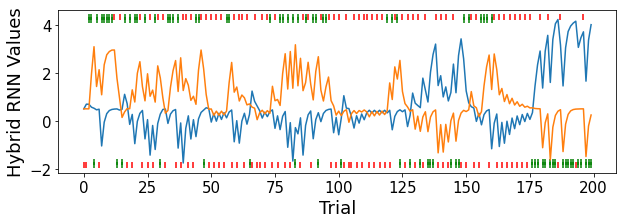

In [177]:
sess_i = 1
choices = xs[:, sess_i, 0]
rewards = xs[:, sess_i, 1]

hybrnn_values = v[:, sess_i, :]
hybrnn_v_state = v_state[:, sess_i, :]


bandits.plot_session(choices=choices,
                     rewards=rewards,
                     timeseries=hybrnn_values,
                     timeseries_name='Hybrid RNN Values')




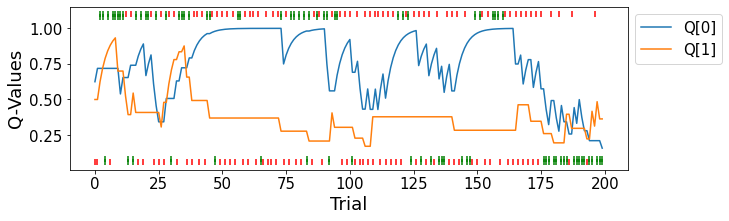

In [178]:
bandits.plot_session(
    choices=choices, rewards=rewards, timeseries=qs, timeseries_name='Q-Values',
    labels=[f'Q[{a}]' for a in range(n_actions)])

In [179]:
print('Normalized Likelihoods for Hybrid RNN')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, make_hybrnn, hybrnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_hybrnn, hybrnn_params)

Normalized Likelihoods for Hybrid RNN
Training Dataset
Normalized Likelihood: 66.2%
Held-Out Dataset
Normalized Likelihood: 65.7%


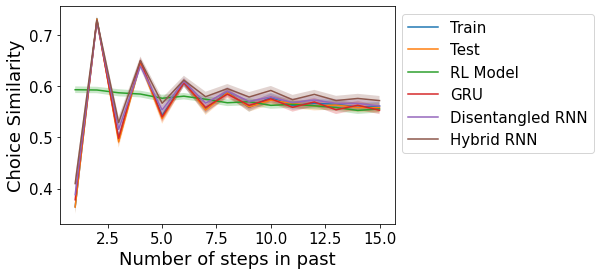

In [180]:
plotting.plot_action_similarity_to_history(
    experiment_list_train,
    experiment_list_test,
    experiment_list_rl,
    experiment_list_gru,
    experiment_list_disrnn,
    experiment_list_hybrnn,
    n_steps_back=16,
    labels=['Train', 'Test', 'RL Model', 'GRU', 'Disentangled RNN', 'Hybrid RNN'],
    bbox_to_anchor=(1, 1))


In [181]:
#@title Save results from this run into a dictionary.
if 'RESULTS' not in locals():
    RESULTS = {}

RESULTS[dataset_type] = {
    'Train': experiment_list_train.copy(),
    'Test': experiment_list_test.copy(),
    'RL Model': experiment_list_rl.copy(),
    'GRU': experiment_list_gru.copy(),
    'Disentangled RNN': experiment_list_disrnn.copy(),
    'Hybrid RNN': experiment_list_hybrnn.copy(),
}

def clear_experiments():
    del experiment_list_train
    del experiment_list_test    
    del experiment_list_rl    
    del experiment_list_gru    
    del experiment_list_disrnn
    del experiment_list_hybrnn

# Part 3: Compare different datasets.

Confirm you have run the cell above, which will save the results of these experiments in `RESULTS`, a dictionary which will hold results for each dataset_type. This will allow us to see how the models compare 

Plot held-out likelihood for Q-Learning fit, GRU, disRNN, Hybrid RNN

Plot timecourse of latents for each of those

# Part 4: Compare different models

Plot held-out likelihood for Q-Learning fit, GRU, disRNN, Hybrid RNN

Plot timecourse of latents for each of those

# Part 5: Work with real data

Congratulations, you have learned about a classic Q-learning agent, about model fitting, about neural networks, and about two new classes of hybrid models!

Now, let's see how we can apply this to a real dataset. Go back to [where we selected our dataset](#fit-classic-cognitive-model) and choose the rat dataset now!

Then, see what happens when you fit the Q-learning model.